## Preparation of pubchem bioassay data into a form appropriate for promiscuity analysis

Note at the start - in order to reproduce this notebook, you'd have to collect the data from [pubchem file transfer protocol](https://ftp.ncbi.nlm.nih.gov/pubchem/Bioassay/Extras/).\
Specifically bioassays.tsv and bioactivities.tsv

Bioactivities especially are quite large, around 20 giga bytes. As such, in order to reproduce this notebook, it is neceassary to download them - instructions are in the project README.

In [1]:
import pandas as pd
import numpy as np

from collections import Counter

### Bioassays.tsv

In [2]:
bioassays_df = pd.read_csv("../data/downloaded/pubchem/bioassays.tsv", sep='\t')

Since the data is quite large, the main goal of this step is to narrow down the set of analyzed AID's to those that we can actually obtain information about promiscuity of compounds from.

This primarily means that we will: 
1. select all "Screening" bioassays (primary assays)
2. collect a set of all targets tested against in the primary assays
3. narrow down "Confirmatory" bioassays (secondary assays) to only those that feature the targets from the list above

In [3]:
bioassays_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1627925 entries, 0 to 1627924
Data columns (total 20 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   AID                    1627925 non-null  int64  
 1   BioAssay Name          1627925 non-null  object 
 2   Deposit Date           1627925 non-null  int64  
 3   Modify Date            1627925 non-null  int64  
 4   Source Name            1627925 non-null  object 
 5   Source ID              1627925 non-null  object 
 6   Substance Type         1627925 non-null  object 
 7   Outcome Type           436774 non-null   object 
 8   Project Category       1627282 non-null  object 
 9   BioAssay Group         1617734 non-null  object 
 10  BioAssay Types         202356 non-null   object 
 11  Protein Accessions     468865 non-null   object 
 12  UniProts IDs           450363 non-null   object 
 13  Gene IDs               450227 non-null   object 
 14  Target TaxIDs     

Later down the analysis we realized we only want to work with assays where we know the target's uniprot id, so we went back here and filter it before all the other analysis.

In [4]:
bioassays_df = bioassays_df.loc[~bioassays_df["UniProts IDs"].isna()].copy()

Let's just confirm that "Screening" and "Confirmatory" means what we think it means,
that "Screening" corresponds to primary assays where a often larger quantities of compounds
are screened to find potential hits, and "Confirmatory" corresponds to secondary assays
that follow up on the primary assays confirm or debunk the activity.

In [5]:
from scripts.visualizations import plot_categorical_numerical
# if this doesn't work, run:
# pip install .
# in the root directory to get the custom packages

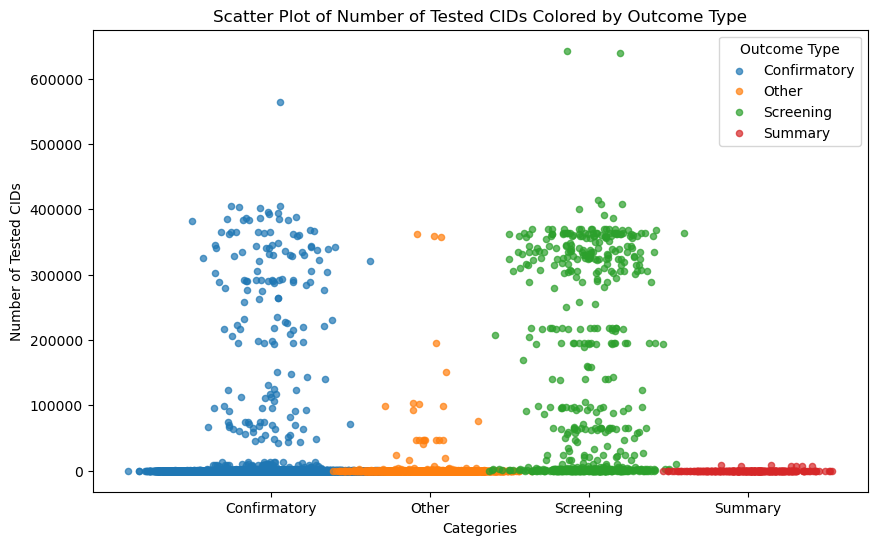

In [6]:
plot_categorical_numerical(bioassays_df, "Outcome Type", "Number of Tested CIDs")

It can be seen that there is a thicker cluster of high-content assays is associated with the Screening tag.
We also have large Confirmatory assays and as such we can declare that we don't need any other data than just screening and confirmatory

In [7]:
primary_secondary_df = bioassays_df.loc[bioassays_df["Outcome Type"].isin(["Screening", "Confirmatory"])].copy()
primary_secondary_df['Outcome Type'] = primary_secondary_df['Outcome Type'].cat.remove_unused_categories()

In [8]:
print(f"Primary_secondary assay coverage: {round(len(primary_secondary_df)* 100.0 / len(bioassays_df), 2)}%")
print(f"Primary_secondary compound coverage: {round(primary_secondary_df['Number of Tested CIDs'].sum() * 100.0 / bioassays_df['Number of Tested CIDs'].sum(), 2)}%")

Primary_secondary assay coverage: 46.57%
Primary_secondary compound coverage: 96.84%


Despite eliminating almost 50% of the assays, we retain almost 97% of the data, which is definitely acceptable.

Now we do a projection, only focusing on columns that are releavant to us.

For the later task of pooling targets, we chose Uniprot IDs to represent target identity.

In [9]:
primary_secondary_df = primary_secondary_df[["AID", "Outcome Type",  "UniProts IDs", "Number of Tested CIDs", "Number of Active CIDs"]] 

Now let's investigate hit rates.

In [10]:
primary_secondary_df["Activity Rate"] = primary_secondary_df["Number of Active CIDs"] / primary_secondary_df["Number of Tested CIDs"]

In [11]:
primary = primary_secondary_df.loc[primary_secondary_df["Outcome Type"] == "Screening"]
print(f"Mean screening assay hit rate: \t\t{round((primary['Activity Rate'] * 100.0).mean(), 2)} %")
print(f"Median screening assay hit rate: \t{round((primary['Activity Rate'] * 100.0).median(), 2)} %")
print(f"Weighed mean primary hit rate: \t\t{round(primary['Number of Active CIDs'].sum() * 100.0/ primary['Number of Tested CIDs'].sum(), 2)} %")
print()
secondary = primary_secondary_df.loc[primary_secondary_df["Outcome Type"] == "Confirmatory"]
print(f"Mean confirmatory assay hit rate: \t{round((secondary['Number of Active CIDs'] * 100.0/ secondary['Number of Tested CIDs']).mean(), 2)} %")
print(f"Median confirmatory assay hit rate: \t{round((secondary['Number of Active CIDs'] * 100.0/ secondary['Number of Tested CIDs']).median(), 2)} %")
print(f"Weighed mean secondary hit rate: \t{round(secondary['Number of Active CIDs'].sum() * 100.0/ secondary['Number of Tested CIDs'].sum(), 2)} %")

Mean screening assay hit rate: 		21.08 %
Median screening assay hit rate: 	1.51 %
Weighed mean primary hit rate: 		0.87 %

Mean confirmatory assay hit rate: 	66.59 %
Median confirmatory assay hit rate: 	96.15 %
Weighed mean secondary hit rate: 	5.96 %


The mean hit rate of screening assays is way too high - we should have a closer look.

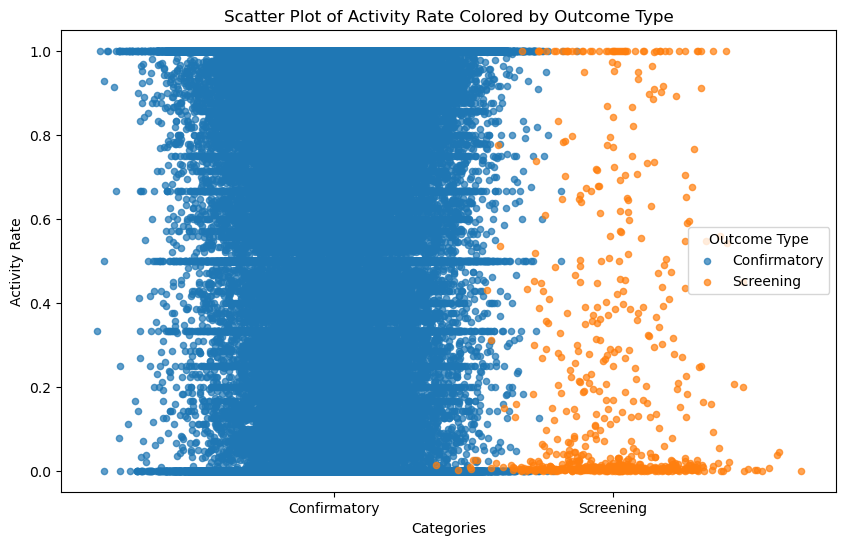

In [12]:
plot_categorical_numerical(primary_secondary_df, "Outcome Type", "Activity Rate")

What all of this tells us is that the mean and median hit rates are so high, because of there being a lot of assays with low amount of compounds and high hit rate, since when we look at the weighed mean hit rate, it is much lower. Lets just visually confirm this

In [13]:
from scripts.visualizations import plot_scatter

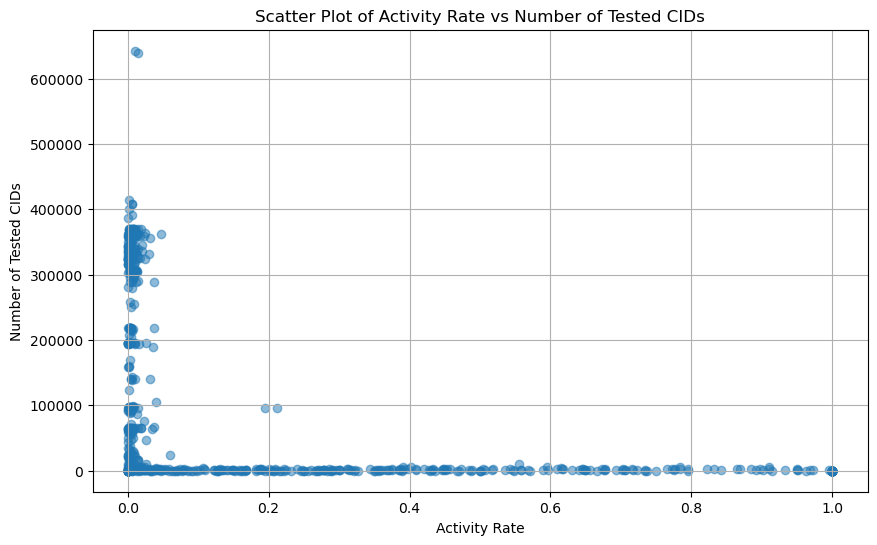

In [14]:
plot_scatter(primary, "Activity Rate", "Number of Tested CIDs")

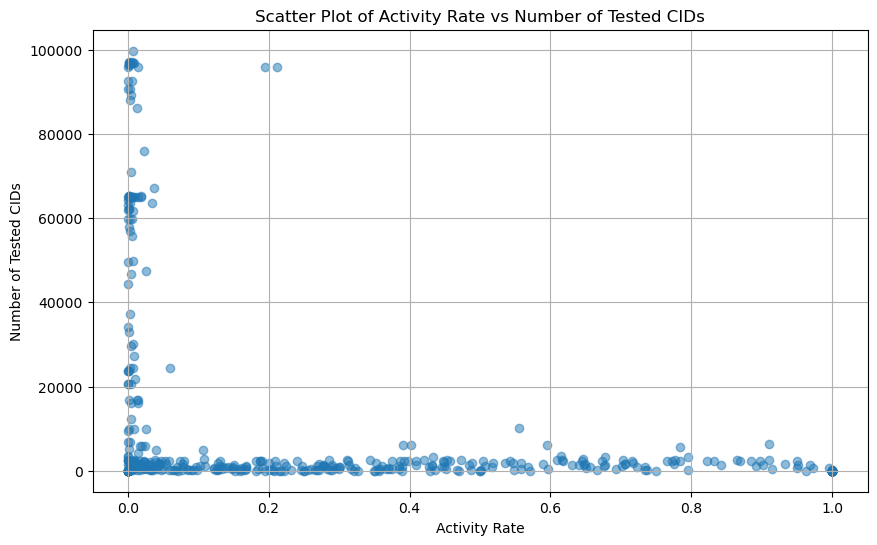

In [15]:
plot_scatter(primary.loc[primary["Number of Tested CIDs"] < 100_000], "Activity Rate", "Number of Tested CIDs")

To ensure that we only work with assays that do not have an overly elevated active rate,
we can do one of the following:
- set a number of tested CIDs cutoff (the graph suggested around 20K compounds)
- set an activity rate cutoff (everything above 20%, or even a more conservative 10%)
- both together

We'd like to not loose too many data points while keeping the weighed mean activity rate as low as possible.

In [16]:
size_cutoff = primary.loc[primary["Number of Tested CIDs"] > 20_000].copy()
activity_cutoff = primary.loc[primary["Activity Rate"] < 0.1].copy()
both_cutoffs = primary.loc[(primary["Number of Tested CIDs"] > 5_000) & (primary["Activity Rate"] < 0.1)].copy()

In [17]:
print(
    f"Size cutoff\n"
    f"\tcompound retention: {size_cutoff['Number of Tested CIDs'].sum() * 100.0 / primary['Number of Tested CIDs'].sum():.2f}%\n"
    f"\thit-rate: {size_cutoff['Number of Active CIDs'].sum() * 100.0 / size_cutoff['Number of Tested CIDs'].sum():.2f}%"
)
print()
print(
    f"Activity cutoff\n"
    f"\tcompound retention: {activity_cutoff['Number of Tested CIDs'].sum() * 100.0 / primary['Number of Tested CIDs'].sum():.2f}%\n"
    f"\thit-rate: {activity_cutoff['Number of Active CIDs'].sum() * 100.0 / activity_cutoff['Number of Tested CIDs'].sum():.2f}%"
)
print()
print(
    f"Size+activity cutoff\n"
    f"\tcompound retention: {both_cutoffs['Number of Tested CIDs'].sum() * 100.0 / primary['Number of Tested CIDs'].sum():.2f}%\n"
    f"\thit-rate: {both_cutoffs['Number of Active CIDs'].sum() * 100.0 / both_cutoffs['Number of Tested CIDs'].sum():.2f}%"
)

Size cutoff
	compound retention: 99.29%
	hit-rate: 0.69%

Activity cutoff
	compound retention: 99.41%
	hit-rate: 0.64%

Size+activity cutoff
	compound retention: 99.27%
	hit-rate: 0.64%


In the end I chose to go with a combination of both

In [18]:
primary_cutoff = both_cutoffs.copy()

Finally, we only want secondary assays that were done on the targets of primary assays.

In [20]:
targets = primary_cutoff["UniProts IDs"].unique()
secondary_cleaned = secondary.loc[secondary["UniProts IDs"].isin(targets)].copy()

In [21]:
cleaned = pd.concat([primary_cutoff, secondary_cleaned])

In [22]:
cleaned

,AID,Outcome Type,UniProts IDs,Number of Tested CIDs,Number of Active CIDs,Activity Rate
184,368,Screening,P30305,65202,84,0.001288
187,372,Screening,P04585,99768,769,0.007708
188,373,Screening,Q99500,59788,62,0.001037
189,374,Screening,P28562,65218,100,0.001533
225,422,Screening,P61981,157962,312,0.001975
...,...,...,...,...,...,...
1627801,1920103,Confirmatory,Q8NER1,116,116,1.000000
1627861,1920163,Confirmatory,P13569,210,192,0.914286
1627882,1920184,Confirmatory,P21462,24,16,0.666667
1627884,1920186,Confirmatory,Q8N884,24,24,1.000000


We narrowed down the set of assays were interested in.

### Pooling uniprot_ids into target classes and families

Targets have varying degrees of similarity, which means that if we only use UniProt IDs for analysis of compound promiscuity, we'll run into an issue where compounds that are active on a target family with a large amount of members will record a much higher activity rate and thus promiscuity. The opposite will be true as well, and compounds promiscuous on more shallow target families will not appear as strongly promiscous as they are.

The solution is to pool targets into highly similar groups, so that promiscouity will be investigated as activity on several different target families or even classes, rather than just on multiple target ids.

For this we will use a combination of panther's protein families (more granular) and the target classifications from Probes & Drugs (wider).

In [23]:
uniprot_ids = cleaned["UniProts IDs"].unique()

In [24]:
uniprot_ids

array(['P30305', 'P04585', 'Q99500', 'P28562', 'P61981', 'P07900',
       'Q92560', 'Q04206', 'P21462', 'P25090', 'P21453', 'P07711',
       'P42858', 'P25774', 'Q13285', 'P17612', 'P13612', 'P09871',
       'P35398', 'P08908', 'P45452', 'P28566', 'P06935', 'O75116',
       'P05186', 'P53350', 'P08482', 'P84022', 'P37231|Q15788', 'Q92731',
       'Q9Y2R2|Q9Y2R2', 'P00748', 'P32501', 'P05866', 'P34913', 'P54760',
       'Q05397', 'O95136', 'P37231|Q9Y6Q9', 'P53779', 'P61105', 'P63103',
       'P63073|Q04637', 'P04062', 'P49146', 'Q15139', 'P33527', 'O43603',
       'Q9Y337', 'P42224', 'P43116', 'P10415', 'Q9HD36', 'Q16548',
       'P11712', 'P33261', 'P37231', 'P25929', 'Q1HVG2', 'Q00987',
       'P19838|Q04206', 'P22736', 'P14598', 'Q9UNQ0', 'P08183', 'P09471',
       'Q9NZJ5', 'P09471|P49795', 'O15492|P09471', 'P50591',
       'Q01196|Q13951', 'P05107|P11215', 'O75884', 'Q99759', 'Q12851',
       'P9WH09|P9WH11', 'P10520', 'P35561', 'Q9XUB2', 'P78417', 'P51452',
       'P25376', 'Q9C0

In [25]:
target_families = pd.read_csv("../data/downloaded/PAD_target_families.csv")

In [26]:
target_families_dict = {uniprot_id : row["target_family"] for index, row in target_families.iterrows() for uniprot_id in str(row["uniprot_id"]).split(";")}

Let's first check if the target families even cover a large enough percentage of the uniprot IDS

In [27]:
coverage_hits = 0
unknown_ids = set()
for uniprot_record in uniprot_ids:
    for uniprot_id in str(uniprot_record).split("|"):
        if uniprot_id in target_families_dict.keys():
            coverage_hits += 1
            break
        else:
            unknown_ids.add(uniprot_id)
print(coverage_hits / len(uniprot_ids))

0.7479338842975206


~75% coverage is worth continuing

In [1]:
def return_pad_protein_families(uniprot_record):
    """For either a single uniprot id, or a | separated records of multiple, returns the first matched protein family based on the Probes and Drugs annotation"""
    for uniprot_id in str(uniprot_record).split("|"):
        target_family = target_families_dict.get(uniprot_id)
        if target_family is not None:
            return target_family
    return None

In [29]:
cleaned["target_family"] = cleaned["UniProts IDs"].apply(return_pad_protein_families)

In [30]:
cleaned.loc[primary_secondary_df["Outcome Type"] == "Screening", "target_family"].value_counts()

target_family
GPCR                    64
Other                   55
Hydrolase               45
Kinase                  20
Transferase             18
Nuclear receptor        15
Ion channel             15
Epigenetic regulator    10
Transporter              6
Cytochrome P450          2
Oxidoreductase           2
Name: count, dtype: int64

In [31]:
cleaned.groupby("target_family").agg(tested_compounds = ("Number of Tested CIDs", "sum")).reset_index()

,target_family,tested_compounds
0,Cytochrome P450,222566
1,Epigenetic regulator,2741214
2,GPCR,17979421
3,Hydrolase,10196023
4,Ion channel,3660118
5,Kinase,4396585
6,Nuclear receptor,3265230
7,Other,14017261
8,Oxidoreductase,593742
9,Transferase,3819641


In [32]:
panther_ontology = pd.read_csv("../data/downloaded/panther_protein_families.tsv", sep='\t')[['id', 'family']]

In [33]:
panther_ontology_dict = {row['id']: row['family'] for index, row in panther_ontology.iterrows()}

In [34]:
def return_panther_protein_families(uniprot_record):
    for uniprot_id in str(uniprot_record).split("|"):
        target_family = panther_ontology_dict.get(uniprot_id)
        if target_family is not None:
            return target_family
    return None

In [35]:
cleaned["panther_family"] = cleaned["UniProts IDs"].apply(return_panther_protein_families)

In [36]:
family_to_subfamily = {row['panther_family']: set() for index, row in cleaned.iterrows()}
for index, row in cleaned.iterrows():
    family_to_subfamily[row['panther_family']].add(row['target_family'])

In [37]:
cleaned['target_family'].isna().sum() / len(cleaned)

0.03298409002716337

In [38]:
for key, val in family_to_subfamily.items():
    if len(val) > 1:
        for item in val:
            if item is not None:
                family_to_subfamily[key] = item
    else:
        family_to_subfamily[key] = list(val)[0]

In [39]:
family_to_subfamily

{'M-PHASE INDUCER PHOSPHATASE 2 (PTHR10828:SF48)': 'Hydrolase',
 None: None,
 'SPHINGOSINE 1-PHOSPHATE RECEPTOR 3 (PTHR22750:SF24)': 'GPCR',
 'DUAL SPECIFICITY PROTEIN PHOSPHATASE 1 (PTHR10159:SF309)': 'Hydrolase',
 '14-3-3 PROTEIN GAMMA (PTHR18860:SF22)': 'Other',
 'HEAT SHOCK PROTEIN HSP 90-ALPHA (PTHR11528:SF87)': 'Other',
 'UBIQUITIN CARBOXYL-TERMINAL HYDROLASE BAP1 (PTHR10589:SF28)': None,
 'TRANSCRIPTION FACTOR P65 (PTHR24169:SF1)': 'Transferase',
 'FMET-LEU-PHE RECEPTOR (PTHR24225:SF60)': 'GPCR',
 'N-FORMYL PEPTIDE RECEPTOR 2 (PTHR24225:SF0)': 'GPCR',
 'SPHINGOSINE 1-PHOSPHATE RECEPTOR 1 (PTHR22750:SF16)': 'GPCR',
 'PROCATHEPSIN L (PTHR12411:SF902)': 'Hydrolase',
 'HUNTINGTIN (PTHR10170:SF10)': 'Other',
 'CATHEPSIN S (PTHR12411:SF525)': 'Hydrolase',
 'STEROIDOGENIC FACTOR 1 (PTHR24086:SF24)': 'Nuclear receptor',
 'CAMP-DEPENDENT PROTEIN KINASE CATALYTIC SUBUNIT ALPHA (PTHR24353:SF82)': 'Kinase',
 'INTEGRIN ALPHA-4 (PTHR23220:SF78)': 'Other',
 'COMPLEMENT C1S SUBCOMPONENT (PTHR24

In [40]:
cleaned['target_family'] = cleaned['panther_family'].map(family_to_subfamily)

In [41]:
cleaned['target_family'], target_fam_table = pd.factorize(cleaned['target_family'])

In [42]:
cleaned['panther_family'], panther_fam_table = pd.factorize(cleaned['panther_family'])

In [43]:
pd.DataFrame(target_fam_table).reset_index().to_csv("../data/target_families_table.csv", index=False)

In [44]:
pd.DataFrame(panther_fam_table).reset_index().to_csv("../data/panther_families_table.csv", index=False)

In [45]:
cleaned["Outcome Type"] = np.where(cleaned["Outcome Type"] == "Screening", 1, 2)

In [46]:
cleaned.to_csv("../data/bioassays_all_targets_encoded.csv", index=False)

In [47]:
cleaned

,AID,Outcome Type,UniProts IDs,Number of Tested CIDs,Number of Active CIDs,Activity Rate,target_family,panther_family
184,368,1,P30305,65202,84,0.001288,0,0
187,372,1,P04585,99768,769,0.007708,-1,-1
188,373,1,Q99500,59788,62,0.001037,1,1
189,374,1,P28562,65218,100,0.001533,0,2
225,422,1,P61981,157962,312,0.001975,2,3
...,...,...,...,...,...,...,...,...
1627801,1920103,2,Q8NER1,116,116,1.000000,7,143
1627861,1920163,2,P13569,210,192,0.914286,7,131
1627882,1920184,2,P21462,24,16,0.666667,1,7
1627884,1920186,2,Q8N884,24,24,1.000000,3,213


### bioactivities.csv

In [48]:
bioactivities_df = pd.read_csv("../data/created/bioactivities_c1_4_5.tsv", sep = "\t")

Immediately we have the option to greatly decrease the size of the data, by only keeping records with AID that appears within our bioassays set.

In [49]:
bioactivities_df = bioactivities_df.loc[bioactivities_df["AID"].isin(cleaned["AID"].unique())].copy()

Check for missing data

In [50]:
bioactivities_df.isna().sum()

AID                    0
CID                 5009
Activity Outcome       0
dtype: int64

We dont care for records of unknown compounds as we're looking to understand structures

In [51]:
bioactivities_df = bioactivities_df.loc[~bioactivities_df['CID'].isna()]
bioactivities_df.isna().sum()

AID                 0
CID                 0
Activity Outcome    0
dtype: int64

Now that we don't need to deal with missing values, we can downcast to ints, and outcome to bool

In [52]:
bioactivities_df['Activity Outcome'].value_counts()

Activity Outcome
Inactive        93682047
Active            849336
Inconclusive      754786
Unspecified       120009
Probe                  2
Name: count, dtype: int64

To analyze promiscuity, we're only interested in whether the compound was active or inactive.
The question is whether to transform the Inconclusive value into Inactive or get rid of it. 
As the Inconclusive records only cover a small portion of the data, I believe it is best to get rid of them entirely and only work with records that had been determined to be either Active or Inactive.

In [53]:
bioactivities_df = bioactivities_df.loc[bioactivities_df['Activity Outcome'].isin(['Active', 'Inactive'])] 
bioactivities_df['Activity Outcome'].value_counts()

Activity Outcome
Inactive    93682047
Active        849336
Name: count, dtype: int64

These can now be transformed into a boolean feature.

In [54]:
bioactivities_df['active'] = np.where(bioactivities_df['Activity Outcome'] == 'Active', True, False)
bioactivities_df = bioactivities_df.drop("Activity Outcome", axis=1)
bioactivities_df.dtypes

AID         int64
CID       float64
active       bool
dtype: object

Now let's downcast both AID and CID cols to smallest possible integers

In [55]:
bioactivities_df['AID'] = pd.to_numeric(bioactivities_df['AID'], downcast="integer")
bioactivities_df['CID'] = bioactivities_df['CID'].astype('int')
bioactivities_df['CID'] = pd.to_numeric(bioactivities_df['CID'], downcast="integer")

bioactivities_df.dtypes

AID       int32
CID       int32
active     bool
dtype: object

Let's have a look at the distribution of how many assays each compound has encountered.

In [56]:
cids = bioactivities_df.groupby("CID").agg(occs = ("CID","size")).reset_index()

In [57]:
from scripts.visualizations import plot_histogram

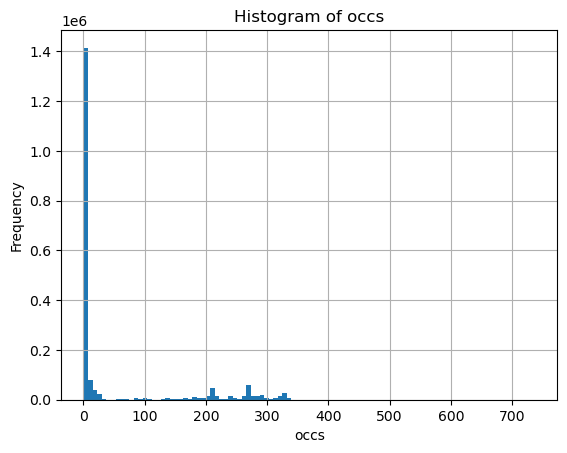

In [58]:
plot_histogram(cids, "occs")

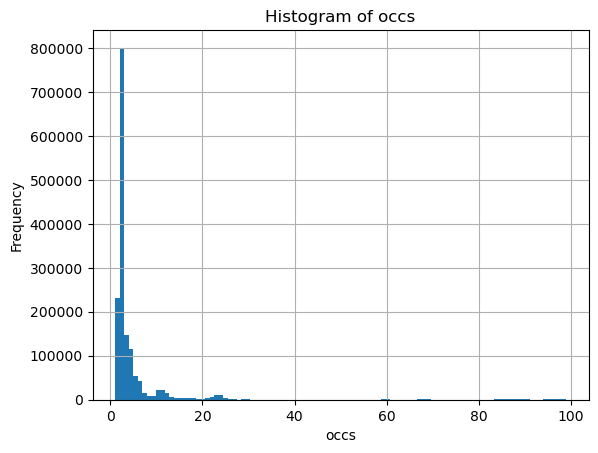

In [59]:
plot_histogram(cids.loc[cids["occs"] < 100], "occs")

A natural cut off of at least 20 assays presents itself.

In [60]:
bioactivities_df = bioactivities_df.loc[bioactivities_df["CID"].isin(cids.loc[cids["occs"] >= 20, "CID"].unique())].copy()

In [61]:
bioactivities_df

,AID,CID,active
5255136,348,229300,False
5255137,348,229969,False
5255168,348,290218,False
5255169,348,332281,False
5255210,348,97098,False
...,...,...,...
293874320,1920017,2423905,True
293874321,1920017,2423905,True
293874322,1920017,2081017,True
293874323,1920017,2110924,True


In [62]:
bioactivities_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89921478 entries, 5255136 to 293874324
Data columns (total 3 columns):
 #   Column  Dtype
---  ------  -----
 0   AID     int32
 1   CID     int32
 2   active  bool 
dtypes: bool(1), int32(2)
memory usage: 1.4 GB


The dataframe is now ready to be combined with the bioassay data.

In [63]:
bioactivities_df.to_csv("../data/bioactivities_cleaned.csv", index=False)

## Merging bioassay and bioactivities data

Our goal is to create the following records:


- CID
- Uniprot IDs
- panther family
- target family
- Outcome Type (whether this was a primary or secondary assay)
- Active (bool)

The resulting dataframe will be massive, so lets first figure out a id mapping for assay groups and targets

Load the df again if not saved from previous steps

In [64]:
primary_secondary_df = pd.read_csv("../data/bioassays_all_targets_encoded.csv")

In [65]:
primary_secondary_df = primary_secondary_df.loc[~((primary_secondary_df["target_family"] == -1) | (primary_secondary_df["panther_family"] == -1))]

In [66]:
bioactivities_df

,AID,CID,active
5255136,348,229300,False
5255137,348,229969,False
5255168,348,290218,False
5255169,348,332281,False
5255210,348,97098,False
...,...,...,...
293874320,1920017,2423905,True
293874321,1920017,2423905,True
293874322,1920017,2081017,True
293874323,1920017,2110924,True


In [67]:
df = pd.merge(bioactivities_df, primary_secondary_df[["AID", "Outcome Type", "target_family", "panther_family"]], on="AID", how="inner")

In [68]:
df.to_csv("../data/pubchem_bioactivities_merged.csv", index=False)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68674133 entries, 0 to 68674132
Data columns (total 6 columns):
 #   Column          Dtype
---  ------          -----
 0   AID             int32
 1   CID             int32
 2   active          bool 
 3   Outcome Type    int64
 4   target_family   int64
 5   panther_family  int64
dtypes: bool(1), int32(2), int64(3)
memory usage: 2.1 GB


This is where the data preparation ends. This notebook has been separated from the rest of the analysis mainly due to dealing with large amounts of data, which is not exactly suitable for reproduction. I still wanted the steps taken to be clearly noted somewhere though, which is why this notebook is also avaialable in the repo, despite not being possible to run without the data.

The promiscuity analysis itself will be in a different notebook, with the data downloadable - which means it will be reproducible.